# **<center>Deep learning<center>**
# **<center>MSc in Artificial Intelligence<center>**
# **<center>Spilios Dellis<center>**

# **Libraries and Functions**

## **Improrting necessary libraries**

In [53]:
! pip install noisereduce
! pip install efficientnet
! pip install mutagen

from google.colab import drive, files
drive.mount('/content/gdrive')

%matplotlib inline
import IPython
import numpy as np 
import random
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
import noisereduce as no
from subprocess import run
from shlex import split
from fastprogress.fastprogress import progress_bar
import multiprocessing
from joblib import Parallel, delayed
import cv2
import os
import warnings
import IPython
from imgaug import augmenters as iaa
from tqdm import tqdm
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from matplotlib.pyplot import imread
import tensorflow.keras.applications as applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Input, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.callbacks import ModelCheckpoint, LambdaCallback, Callback,EarlyStopping
from tensorflow.keras import metrics
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras import backend as K
from tensorflow.keras.applications import ResNet50, EfficientNetB0, InceptionV3
from keras.utils.vis_utils import plot_model
import tensorflow as tf
import keras
import pickle
sns.set()
warnings.filterwarnings("ignore")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## **Useful Functions, lists and directories**

## **Data download and directories**

In [ ]:
datapath = '/content/gdrive/MyDrive/ColabNotebooks/DeepLearning_FinalProject'
run(split('mkdir ' + os.path.join(datapath, 'Melgram')))
run(split('mkdir ' + os.path.join(datapath, 'Data')))
run(split('mkdir ' + os.path.join(datapath, 'ff1010bird_wav')))
run(split('mkdir ' + os.path.join(datapath, 'warblrb10k_public_wav')))

! wget https://ndownloader.figshare.com/files/6035814
! wget https://archive.org/download/ff1010bird/ff1010bird_wav.zip
! unzip ff1010bird_wav.zip
run(split('unzip ff1010bird_wav.zip - d' + os.path.join(datapath, 'ff1010bird_wav')))
! wget https://ndownloader.figshare.com/files/6035817
! wget https://archive.org/download/warblrb10k_public/warblrb10k_public_wav.zip
run(split('unzip ff1010bird_wav.zip - d' + os.path.join(datapath, 'warblrb10k_public_wav')))

### **Helper functions**

#### **Functions for the data overview**

In [54]:

run(split('mkdir ' + os.path.join(datapath, 'Melgram')))


def get_audio(name):
  
  if name.isnumeric():

    audio, sr = librosa.load(os.path.join(datapath, 'ff1010bird_wav/wav', name + '.wav'))

  else:

    audio, sr = librosa.load(os.path.join(datapath, 'warblrb10k_public_wav/wav', name + '.wav'))

  audio = no.reduce_noise(y=audio, y_noise=audio, sr=sr)
  saveMel(audio, sr, os.path.join(datapath, 'Melgram', name + '.jpg'))


def saveMel(y, SR,  directory):
    N_FFT = 1024  # Number of frequency bins for Fast Fourier Transform
    HOP_SIZE = 1024  # Number of audio frames between STFT columns
    N_MELS = 128  # Mel band parameters
    WIN_SIZE = 1024  # number of samples in each STFT window
    WINDOW_TYPE = "hann"  # the windowin function
    FEATURE = "mel"  # feature representation

    fig = plt.figure(1, frameon=False)
    fig.set_size_inches(6, 6)
    ax = plt.Axes(fig, [0.0, 0.0, 1.0, 1.0])
    ax.set_axis_off()
    fig.add_axes(ax)
    librosa.display.specshow(
        librosa.core.amplitude_to_db(
            librosa.feature.melspectrogram(
                y=y,
                sr=SR,
                n_fft=N_FFT,
                hop_length=HOP_SIZE,
                n_mels=N_MELS,
                htk=True,
                fmin=0,
                fmax=SR / 2.0,
            ),
            ref=1,
        ),
        sr=SR,
        hop_length=HOP_SIZE,
    )
    fig.savefig(directory, transparent = False)
    fig.clear()
    ax.cla()
    plt.clf()
    plt.close("all")

def Melspectrogram(directory):

    N_FFT = 1024  # Number of frequency bins for Fast Fourier Transform
    HOP_SIZE = 1024  # Number of audio frames between STFT columns
    N_MELS = 128  # Mel band parameters
    WIN_SIZE = 1024  # number of samples in each STFT window
    WINDOW_TYPE = "hann"  # the windowin function
    FEATURE = "mel"  # feature representation
    audio, SR = librosa.load(directory)

    # reducing noise
    audio = no.reduce_noise(y=audio, y_noise=audio, sr=SR)

    # creating logmelspec
    logmelspec = librosa.core.amplitude_to_db(
        librosa.feature.melspectrogram(
            y=audio,
            S=np.abs(
                librosa.stft(
                    audio,
                    n_fft=N_FFT,
                    hop_length=HOP_SIZE,
                    window=WINDOW_TYPE,
                    win_length=WIN_SIZE,
                )
            )
            ** 2,
            sr=SR,
            n_fft=N_FFT,
            hop_length=HOP_SIZE,
            n_mels=N_MELS,
            htk=True,
            fmin=0.0,
            fmax=SR / 2.0,
        ),
        ref=1.0,
    )
    plt.figure()

    # plotting logmelspec
    librosa.display.specshow(
        logmelspec, sr=SR, hop_length=HOP_SIZE, x_axis="time", y_axis="mel"
    )
    plt.colorbar(format='%+2.0f dB')
    plt.show()

#### **Functions for the classification**

In [55]:
class data_generator:
    
    def create_train(dataset_info, batch_size, shape, augument=False):
        assert shape[2] == 3
        while True:
            random_indexes = np.random.choice(len(dataset_info), batch_size)
            batch_images = np.empty((batch_size, shape[0], shape[1], shape[2]))
            batch_labels = np.zeros((batch_size, 2)) # Creating label tensors for each batch where all 28 values are originally zero
            for i, idx in enumerate(random_indexes):
                image = data_generator.load_image(
                    str(dataset_info[idx]['itemid']), shape)   
                if augument:
                    image = data_generator.augment(image)
                batch_images[i] = image
                batch_labels[i][dataset_info[idx]['hasbird']] = 1 # Change those values to one which are present in the image
            yield tf.convert_to_tensor(batch_images), tf.convert_to_tensor(batch_labels)
            
    # We club the four color channels into one image and that to our set. This can be seen below where we visualise the first five images in our set
    def load_image(path, shape):

        image =  np.array(Image.open(os.path.join(datapath, 'Melgram', str(path) +'.jpg')))
        
        image = cv2.resize(image, (shape[0], shape[1])) # resizing the image
        image = np.divide(image, 255) # Normalising the image
        return image  
                
    # Random augmentation based modification. This means each image appended to our set is rotated or flipped by some degree if augmentation is set to True which it is.
    def augment(image):
        augment_img = iaa.Sequential([
            iaa.OneOf([
                iaa.Affine(rotate=0),
                iaa.Affine(rotate=90),
                iaa.Affine(rotate=180),
                iaa.Affine(rotate=270),
                iaa.Fliplr(0.5),
                iaa.Flipud(0.5),
            ])], random_order=True)
        
        image_aug = augment_img.augment_image(image)
        return image_aug

def f1(y_true, y_pred):
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

def show_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,3))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('accuracy')
    ax[1].plot(history.epoch, history.history["binary_accuracy"], label="Train acc")
    ax[1].plot(history.epoch, history.history["val_binary_accuracy"], label="Validation acc")
    ax[0].legend()
    ax[1].legend()

class History_trained_model(object):
    def __init__(self, history, epoch, params):
        self.history = history
        self.epoch = epoch
        self.params = params

## **Deep learning models**

In [56]:
def create_model_ResNet50(input_shape, n_out):
    
    pretrain_model = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)
    pretrain_model.trainable = False
    
    input_tensor = Input(shape=input_shape)
    bn = BatchNormalization()(input_tensor)
    x = pretrain_model(bn)
    x = Conv2D(128, kernel_size=(1,1), activation='relu')(x)
    x = Flatten()(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(n_out, activation='sigmoid')(x)
    model = Model(input_tensor, output)
    
    return model

def create_NET(input_shape, n_out):
    
  input_tensor = Input(shape=(input_shape))
  bn = BatchNormalization()(input_tensor)
  x = Conv2D(64, 3, 1, padding = 'same', activation='relu')(bn)
  x = BatchNormalization()(x)
  x = Conv2D(64, 3, 1, padding = 'same', activation='relu')(x)
  x = BatchNormalization()(x)
  x = MaxPool2D((2, 2))(x)
  x = Conv2D(128, 3, 1, padding = 'same',  activation='relu')(x)
  x = BatchNormalization()(x)
  x = Conv2D(128, 3, 1, padding = 'same',  activation='relu')(x)
  x = BatchNormalization()(x)
  x = Conv2D(128, 3, 1, padding = 'same',  activation='relu')(x)
  x = BatchNormalization()(x)
  x = MaxPool2D((2, 2))(x)
  x = Conv2D(256, 3, 1, padding = 'same',  activation='relu')(x)
  x = BatchNormalization()(x)
  x = Conv2D(256, 3, 1, padding = 'same',  activation='relu')(x)
  x = BatchNormalization()(x)
  x = Conv2D(256, 3, 1, padding = 'same', activation='relu')(x)
  x = BatchNormalization()(x)
  x = MaxPool2D((2, 2))(x)
  x = Conv2D(256, 3, 1, padding = 'same',  activation='relu')(x)  
  x = BatchNormalization()(x)
  x = Conv2D(256, 3, 1, padding = 'same',  activation='relu')(x)
  x = BatchNormalization()(x)
  x = Conv2D(256, 3, 1, padding = 'same', activation='relu')(x)
  x = BatchNormalization()(x)
  x = MaxPool2D((2, 2))(x)
  x = Conv2D(256, 3, 1, padding = 'same',  activation='relu')(x)
  x = BatchNormalization()(x)
  x = Conv2D(256, 3, 1, padding = 'same',  activation='relu')(x)
  x = BatchNormalization()(x)
  x = Conv2D(256, 3, 1, padding = 'same', activation='relu')(x)
  x = BatchNormalization()(x)
  x = MaxPool2D((2, 2))(x)
  x = Conv2D(256, 3, 1, padding = 'same',  activation='relu')(x)
  x = BatchNormalization()(x)
  x = Conv2D(256, 3, 1, padding = 'same',  activation='relu')(x)
  x = BatchNormalization()(x)
  x = Conv2D(256, 3, 1, padding = 'same', activation='relu')(x)
  x = BatchNormalization()(x)
  x = MaxPool2D((2, 2))(x)
  x = Conv2D(512, 3, 1, padding = 'same',  activation='relu')(x)
  x = BatchNormalization()(x)
  x = Conv2D(512, 3, 1, padding = 'same',  activation='relu')(x)
  x = BatchNormalization()(x)
  x = Conv2D(512, 3, 1, padding = 'same', activation='relu')(x)
  x = BatchNormalization()(x)
  x = MaxPool2D((2, 2))(x)
  x = Conv2D(512, 3, 1, padding = 'same',  activation='relu')(x)
  x = BatchNormalization()(x)
  x = Conv2D(512, 3, 1, padding = 'same',  activation='relu')(x)
  x = BatchNormalization()(x)
  x = Conv2D(512, 3, 1, padding = 'same', activation='relu')(x)
  x = BatchNormalization()(x)
  x = MaxPool2D((2, 2))(x)
  x = Flatten()(x)
  x = Dropout(0.5)(x)
  x = Dense(512, activation='relu')(x)
  x = Dropout(0.5)(x)
  output = Dense(n_out, activation='sigmoid')(x)
  model = Model(input_tensor, output)
    
  return model

# **Main body of the Project**

In this project wo different architectures were employed for the detection of bird sounds on audio recordings of the dataset of the Bird Audio Detection challenge of the Machine Listening Lab of the Queen Mary University of London (http://machine-listening.eecs.qmul.ac.uk/bird-audio-detection-challenge/) was employed. The first architecture was based on a multilayer convolution neural network (G. Gupta et al.  https://doi.org/10.1038/s41598-021-96446-w) and the second one is based on the RENET50 pre-trained model. 

## **Data Overview**

The dataset used for the training and evaluation of the deep learning models consist of 10 s wav files. Specifically, two different dataset were merged to have examples of audio recordings of birds in different areas as well as to make the training dataset balanced. The first dataset comes  from freefield1010 – a collection of over 7,000 excerpts from field recordings around the world, gathered by the FreeSound project, and then standardised for research. This collection is very diverse in location and environment.  This dataset can be download from https://archive.org/download/ff1010bird/ff1010bird_wav.zip and the respective labels from  https://ndownloader.figshare.com/files/6035814. The second data comes from a UK bird-sound crowdsourcing research spinout called Warblr and is consist of 10,000 ten-second smartphone audio recordings from around the UK. The audio totals around 44 hours duration. T. The audio covers a wide distribution of UK locations and environments, and includes weather noise, traffic noise, human speech and even human bird imitations. It is directly representative of the data that is collected from a mobile crowdsourcing initiative. In the resulted dataset 51 % of the files contain bird sound. 

In [37]:
ff1010bird = pd.read_csv(os.path.join(datapath, '6035814'), delimiter=',')
warblrb10k = pd.read_csv(os.path.join(datapath, '6035817'), delimiter=',')
labels = pd.concat([ff1010bird, warblrb10k], ignore_index=True)

_labels, test_labels = train_test_split(labels, test_size = 0.1)
train_labels, validation_labels = train_test_split(_labels, test_size = 0.2)

Characteristic audio recording of the two dataset with and without bird sound on them can be heard below. 

*   **WARBLRB dataset with bird sound**






In [38]:
IPython.display.Audio(os.path.join(datapath, 'warblrb10k_public_wav/wav/3c39871d-16c2-427f-8103.wav'))

*   **WARBLRB dataset without bird sound**

In [39]:
IPython.display.Audio(os.path.join(datapath, 'warblrb10k_public_wav/wav/c82f5866-431a-490d-8ce3.wav'))

*   **FF1010 dataset with bird sound**

In [40]:
IPython.display.Audio(os.path.join(datapath, 'ff1010bird_wav/wav/101423.wav'))

**FF1010 dataset without bird sound**

In [41]:
IPython.display.Audio(os.path.join(datapath, 'ff1010bird_wav/167363.wav'))

## **Deep learning classification**

### **Data processing**

In [ ]:
data_labels = {name:label for name, label in labels.values}
Parallel(n_jobs=multiprocessing.cpu_count())(delayed(get_audio)(str(itemid)) for itemid, label in progress_bar(data_labels.items()))

Mel spectrogram were prepared for each one of the audio recording used the librosa library. The Mel spectrogram were saved in a jpg format and then are used for the training of the model.

Characteristic mel spectrograms from audio recording with and without bird sound on them are presented below.

*   **WARBLRB dataset with bird sound**

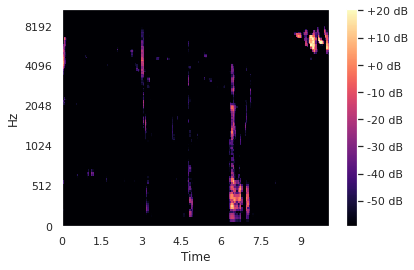

In [57]:
Melspectrogram(os.path.join(datapath, 'warblrb10k_public_wav/wav/3c39871d-16c2-427f-8103.wav'))

*   **WARBLRB dataset without bird sound**

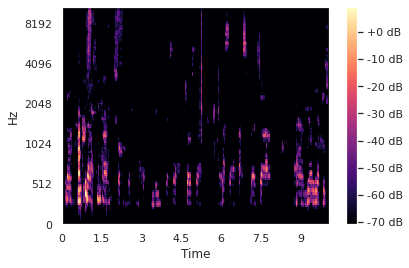

In [58]:
Melspectrogram(os.path.join(datapath, 'warblrb10k_public_wav/wav/c82f5866-431a-490d-8ce3.wav'))

*   **FF1010 dataset with bird sound**

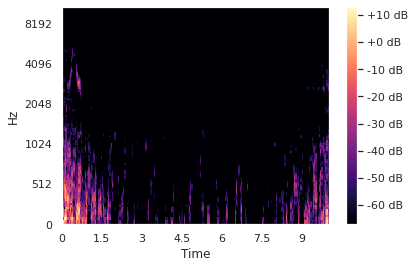

In [59]:
Melspectrogram(os.path.join(datapath, 'ff1010bird_wav/wav/101423.wav'))

**FF1010 dataset without bird sound**

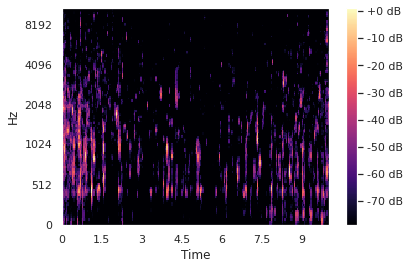

In [60]:
Melspectrogram(os.path.join(datapath, 'ff1010bird_wav/wav/167363.wav'))

In [ ]:
INPUT_SHAPE = (299,299,3)
BATCH_SIZE = 32

train_dataset_info = []
for i in range(len(labels)):
  train_dataset_info.append({'itemid' : str(labels['itemid'][i]), 'hasbird' : labels['hasbird'][i] })

train_dataset_info = np.array(train_dataset_info)

train_ids, validation_ids, train_targets, validation_target = train_test_split(labels['itemid'], labels['hasbird'], test_size=0.05, random_state=42)
train_ids, test_ids, train_targets, test_target = train_test_split(train_ids, train_targets, test_size=0.2, random_state=42)

train_generator = data_generator.create_train(train_dataset_info[train_ids.index], BATCH_SIZE, INPUT_SHAPE)
test_generator = data_generator.create_train(train_dataset_info[test_ids.index], 256, INPUT_SHAPE)

### **Models**

#### **CNN-based model**

The first model studied in this project was a multilayer convolution neural network (CNN).The model consist of 23 layers and the architecture is based on the work of *Gupta G. et al.* (https://github.com/microsoft/bird-acoustics-rcnn). The validation loss was used as figure of merit for the selection of the best model. The model has 20463310 parameters with the 20449992 be trainable.

In [ ]:
tf.keras.backend.clear_session()
modelCNN = create_NET(input_shape=INPUT_SHAPE,n_out=2)
modelCNN.summary()   
plot_model(modelCNN, to_file=os.path.join(datapath, 'Data/CNN_model_plot.png'), show_shapes=True, show_layer_names=True)
Image.open(os.path.joint(datapath, 'Data/CNN_model_plot.png'))

checkpointer = ModelCheckpoint(os.path.join(datapath, 'Data/CNN_model.model'), verbose=1, save_best_only=True)
earlystoper = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=5,verbose=1)
modelCNN.layers[2].trainable = False
modelCNN.compile(loss='binary_crossentropy', optimizer=Adam(1e-3), metrics=['binary_accuracy'])
historyCNN = modelCNN.fit_generator(train_generator, steps_per_epoch=int(len(train_ids)/BATCH_SIZE), validation_data=next(test_generator), epochs=200, verbose=1, callbacks=[checkpointer,earlystoper])

with open(os.path.join(datapath, 'Data/historyCNN'), 'wb') as file:
    model_history= History_trained_model(historyCNN.history, historyCNN.epoch, historyCNN.params)
    pickle.dump(model_history, file, pickle.HIGHEST_PROTOCOL)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 batch_normalization (BatchN  (None, 299, 299, 3)      12        
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 299, 299, 64)      1792      
                                                                 
 batch_normalization_1 (Batc  (None, 299, 299, 64)     256       
 hNormalization)                                                 
                                                                 
 conv2d_1 (Conv2D)           (None, 299, 299, 64)      36928     
                                                                 
 batch_normalization_2 (Batc  (None, 299, 299, 64)     256   

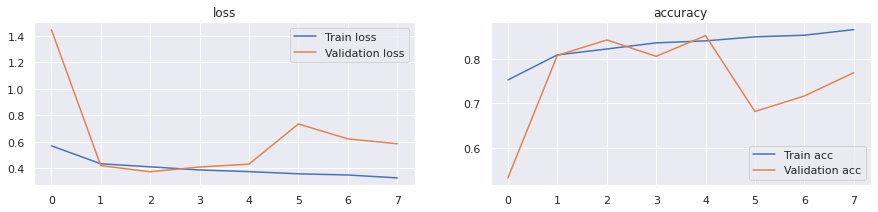

In [ ]:
show_history(historyCNN)

#### **RESNet50-based model**


The second model was based on the RESNet50 model. The pretrained on ImageNet weigths were kept in the model, except of the last layer. The model has 30405134
 with the 6817416 of them be trainable.

In [ ]:
tf.keras.backend.clear_session()
modelResNet50 = create_model_ResNet50(input_shape=INPUT_SHAPE,n_out=2)
modelResNet50.summary()   
plot_model(modelResNet50, to_file=os.path.join(datapath, 'Data/RESNET50_model_plot.png'), show_shapes=True, show_layer_names=True)
Image.open(os.path.join(datapath, 'Data/RESNET50_model_plot.png'))

checkpointer = ModelCheckpoint(os.path.join(datapath, 'Data/RESNET50.model'), verbose=1, save_best_only=True)
earlystoper = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=5,verbose=1)
modelResNet50.layers[2].trainable = False
modelResNet50.compile(loss='binary_crossentropy', optimizer=Adam(1e-3), metrics=['binary_accuracy'])
historyResNet50 = modelResNet50.fit_generator(train_generator, steps_per_epoch=int(len(train_ids)/BATCH_SIZE), validation_data=next(test_generator), epochs=200, verbose=1, callbacks=[checkpointer,earlystoper])

with open(os.path.join(datapath, 'Data/historyResNet50'), 'wb') as file:
    model_history= History_trained_model(historyResNet50.history, historyResNet50.epoch, historyResNet50.params)
    pickle.dump(model_history, file, pickle.HIGHEST_PROTOCOL)

94781440/94765736 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 batch_normalization (BatchN  (None, 299, 299, 3)      12        
 ormalization)                                                   
                                                                 
 resnet50 (Functional)       (None, 10, 10, 2048)      23587712  
                                                                 
 conv2d (Conv2D)             (None, 10, 10, 128)       262272    
                                                                 
 flatten (Flatten)           (None, 12800)             0         
                                                                 
 dropout (Dropout)           (None, 12800)             0      

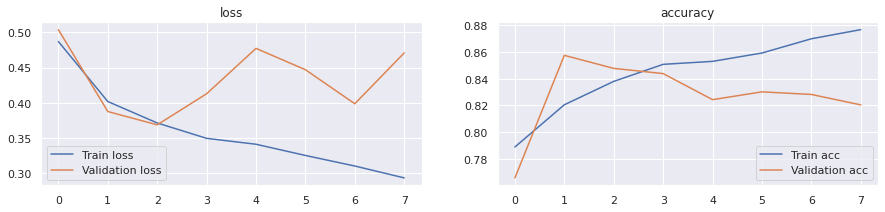

In [ ]:
show_history(historyResNet50)

### **Comparison of the models**

In [ ]:
RESNET50Evalmodel = create_model_ResNet50(input_shape=INPUT_SHAPE,n_out=2)
RESNET50Evalmodel.load_weights(os.path.join(datapath, 'Data/RESNET50.model'))
CNNEvalmodel = create_NET(input_shape=INPUT_SHAPE,n_out=2)
CNNEvalmodel.load_weights(os.path.join(datapath, 'Data/CNN_model.model'))

In [61]:
validation_generator = data_generator.create_train(train_dataset_info[validation_ids.index], len(validation_ids), INPUT_SHAPE, augument=False)
A = next(validation_generator)

print('RESNET50 based model')
RESNET50_ypred = RESNET50Evalmodel.predict(A[0], batch_size = 8, verbose = 1)

for pos in RESNET50_ypred:
  for i in range(len(pos)):
    if pos[i]>=0.5:
      pos[i] = 1
    else:
      pos[i] = 0

print(classification_report(A[1], RESNET50_ypred))

RESNET50 based model
99/99 [==============================] - 3s 30ms/step
              precision    recall  f1-score   support

           0       0.80      0.87      0.83       372
           1       0.88      0.79      0.83       413

   micro avg       0.84      0.83      0.83       785
   macro avg       0.84      0.83      0.83       785
weighted avg       0.84      0.83      0.83       785
 samples avg       0.83      0.83      0.83       785



In [ ]:
validation_generator = data_generator.create_train(train_dataset_info[validation_ids.index], len(validation_ids), INPUT_SHAPE, augument=False)
A = next(validation_generator)
print('CNN based model')
CNN_ypred = CNNEvalmodel.predict(A[0], batch_size = 8, verbose = 1)

for pos in CNN_ypred:
  for i in range(len(pos)):
    if pos[i]>=0.5:
      pos[i] = 1
    else:
      pos[i] = 0

print(classification_report(A[1], CNN_ypred))

CNN based model
99/99 [==============================] - 6s 44ms/step
              precision    recall  f1-score   support

           0       0.78      0.90      0.84       398
           1       0.89      0.74      0.81       387

   micro avg       0.83      0.82      0.83       785
   macro avg       0.84      0.82      0.82       785
weighted avg       0.84      0.82      0.82       785
 samples avg       0.82      0.82      0.82       785

